In [23]:
import os 
import re 
import string
import pickle
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Force CPU computation
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [26]:
# Hindi font for matplotlib/seaborn
# Please download the hindi font from https://www.wfonts.com/font/nirmala-ui ...
# ... and replace the path next to fname accordingly

from matplotlib.font_manager import FontProperties
hindi_font = FontProperties(fname="/home/nishant/Fonts/nirmala-ui/Nirmala.ttf")

# Data preparation

In [3]:
# Load files
with open("../data/task2/train.en", "r") as f:
    train_en = f.read().split("\n")
    
with open("../data/task2/train.hi", "r") as f:
    train_hi = f.read().split("\n")
    
with open("../data/task2/dev.en", "r") as f:
    dev_en = f.read().split("\n")
    
with open("../data/task2/dev.hi", "r") as f:
    dev_hi = f.read().split("\n")
    
with open("../saved_data/machine_translation/lstm_atn/en_tokenizer.pkl", "rb") as f:
    en_tokenizer = pickle.load(f)
    
with open("../saved_data/machine_translation/lstm_atn/hi_tokenizer.pkl", "rb") as f:
    hi_tokenizer = pickle.load(f)
    
puncts = string.punctuation + train_hi[3][-1]


def preprocess_line(line):
    line = line.translate(str.maketrans("", "", puncts))
    line = re.sub("\u200b", " ", line)
    line = re.sub("\u200d", " ", line)
    line = re.sub("\d+", " ", line)
    line = line.lower()
    line = " ".join(line.split())
    return line

train_en = [preprocess_line(line) for line in train_en]
train_hi = [preprocess_line(line) for line in train_hi]
dev_en = [preprocess_line(line) for line in dev_en]
dev_hi = [preprocess_line(line) for line in dev_hi]

# Evaluation functions

In [80]:
def load_models(enc_path, dec_path):
    encoder_model = load_model(enc_path)
    decoder_model = load_model(dec_path)
    return encoder_model, decoder_model


def translate(input_sentence):
    line = preprocess_line(input_sentence)
    tokens = en_tokenizer.texts_to_sequences([line])
    tokens = pad_sequences(tokens, maxlen=30, padding='post')
    tokens = np.flip(tokens)
    
    enc_out, init_states = encoder_model(tokens)
    dec_in = tf.expand_dims([hi_tokenizer.word_index['startseq']], 1)
    
    words = []
    weight_list = []
    
    for t in range(29):
        preds, init_states, weights = decoder_model([dec_in, enc_out, init_states])
        pred_idx = np.argmax(preds, -1)[0]
        word = hi_tokenizer.index_word.get(pred_idx)
        
        if word is None or word == "endseq":
            break
            
        words.append(word)
        dec_in = tf.expand_dims([pred_idx], 1)
        weight_list.append(weights)
        
    return " ".join(words), weight_list


def evaluate_model(input_sentences, output_sentences):
    actual, predicted = [], []
    for in_line, out_line in tqdm(zip(input_sentences, output_sentences),
                                  total=len(input_sentences)):
        hypothesis, _ = translate(in_line)
        references = out_line
        actual.append([references.split()])
        predicted.append(hypothesis.split())
    
    print("BLEU-1: {:.3f}".format(corpus_bleu(actual, predicted, weights=(1., 0, 0, 0))))
    print("BLEU-2: {:.3f}".format(corpus_bleu(actual, predicted, weights=(.5, .5, 0, 0))))
    print("BLEU-3: {:.3f}".format(corpus_bleu(actual, predicted, weights=(.3, .3, .3, 0))))
    print("BLEU-4: {:.3f}".format(corpus_bleu(actual, predicted, weights=(.25, .25, .25, .25))))
    
    
def plot_attention_weights(weights_list, eng_sentence, hindi_sentence):
    eng_words = preprocess_line(eng_sentence).split()
    hindi_words = hindi_sentence.split()

    weights = np.array(weights_list).squeeze(3).squeeze(1)
    weights = weights[:, -len(eng_words):]
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    sns.heatmap(weights, square=True, cbar=False, cmap='gray', linewidth=0.1, linecolor='white')
    ax.set_xticklabels(eng_words, fontsize=12)
    ax.set_yticklabels(np.flip(hindi_words), fontproperties=hindi_font, fontsize=12)
    plt.title("Attention weights", fontweight='bold', fontsize=15)
    plt.show()

# Model evaluation

In [5]:
# Load models
encoder_model, decoder_model = load_models(
    enc_path = "../saved_data/machine_translation/lstm_atn/models/encoder_30",
    dec_path = "../saved_data/machine_translation/lstm_atn/models/decoder_30"
)

# Train data evaluation
# Evaluating only first 5000 training sentences
evaluate_model(train_en[:5000], train_hi[:5000])

# Development data evaluation
evaluate_model(dev_en, dev_hi)


BLEU-1: 0.362
BLEU-2: 0.270
BLEU-3: 0.242
BLEU-4: 0.172



BLEU-1: 0.198
BLEU-2: 0.082
BLEU-3: 0.051
BLEU-4: 0.018


# Examples

[ENGLISH]: Where are you going?

[HINDI]: कहाँ जा रहे हो




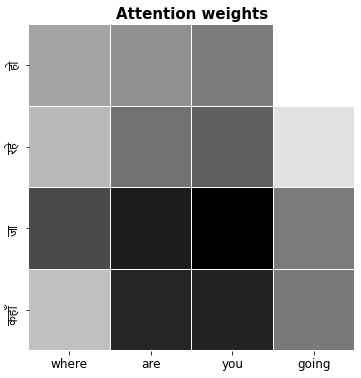

In [83]:
input_sentence = "Where are you going?"
sent, weights = translate(input_sentence)

print("[ENGLISH]: {}".format(input_sentence))
print("\n[HINDI]: {}".format(sent))

# Plot attention weights
print("\n")
plot_attention_weights(weights, input_sentence, sent)